In [2]:
import os
import torch
import matplotlib.pyplot as plt
import PIL.Image as Image
from Datasets import Generate_Dataloader
from Models import Generate_Model
import torchvision.transforms as T
import Model_zoo as models
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

###  Parameters Setting

In [3]:
arch = 'vgg16_bn'
dataset = 'CUB200'#'VOC2012'
num_classes = 200
resume = 'checkpoint_CUB200_vgg16_bn_ft_fixconv_lr-2_lg2_sd0_v2.pth.tar'#'checkpoint_VOC2012_vgg16_bn_ft_fixconv_lr-2_lg2_sd0_v2.pth.tar'
gpu = 2
device_ids = [2]
batch_size = 8

In [4]:
if dataset == 'VOC2012':
    id_class_map = np.load('/home/data1/ruofan/VOCdevkit/VOC2012/OurFiles/id_class_map.npy').tolist()
    id_class_map = [item[:-8] for item in id_class_map]
else:
    id_class_map = list(range(num_classes))
id_class_map

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [5]:
denormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225])
toPIL = T.Compose([denormalize, T.ToPILImage()])

def load_checkpoint(resume, model):
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(device_ids[0])))
        state_dict = checkpoint['state_dict']
        keys = list(state_dict.keys())
        for key in keys:
            if key.find('module'):
                state_dict[key.replace('module.','')] = state_dict.pop(key)

        model.load_state_dict(state_dict)
        print("=> loaded checkpoint '{}' (epoch {} acc1 {})"
              .format(resume, checkpoint['epoch'], checkpoint['best_acc1']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
    del checkpoint, state_dict

In [6]:
model = models.__dict__[arch](num_classes=num_classes)
model.cuda(gpu)
model_gbp = models.__dict__[arch](num_classes=num_classes)
model_gbp.cuda(gpu)
pass

In [7]:
load_checkpoint(resume, model)
model.eval()
load_checkpoint(resume, model_gbp)
model_gbp.eval()
pass

=> loading checkpoint 'checkpoint_CUB200_vgg16_bn_ft_fixconv_lr-2_lg2_sd0_v2.pth.tar'
=> loaded checkpoint 'checkpoint_CUB200_vgg16_bn_ft_fixconv_lr-2_lg2_sd0_v2.pth.tar' (epoch 300 acc1 71.5050048828125)
=> loading checkpoint 'checkpoint_CUB200_vgg16_bn_ft_fixconv_lr-2_lg2_sd0_v2.pth.tar'
=> loaded checkpoint 'checkpoint_CUB200_vgg16_bn_ft_fixconv_lr-2_lg2_sd0_v2.pth.tar' (epoch 300 acc1 71.5050048828125)


### Register Hooks

In [8]:
output_grad_list = []
output_feat_list = []
def hook_backward(module, grad_input, grad_output):
    output_grad_list.append(grad_output[0].data.cpu())
    
def hook_forward(module, input, output):
    output_feat_list.append(output.data.cpu())

output_feat_hook = model.features[40].register_forward_hook(hook_forward)
output_grad_hook = model.features[40].register_backward_hook(hook_backward)

In [9]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()
        
    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            if grad_in[0] is not None:
                self.gradients = grad_in[0].data.cpu()
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)
        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        input_image = torch.autograd.Variable(input_image, requires_grad=True)
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda(gpu)
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data[0]
        return gradients_as_arr

In [10]:
GBP = GuidedBackprop(model_gbp)

### Dataloader

In [11]:
train_loader, val_loader = \
        Generate_Dataloader(dataset, batch_size)

In [15]:
id_class_map = val_loader.dataset.classes
id_class_map = [tt[4:] for tt in id_class_map]
id_class_map

['Black_footed_Albatross',
 'Laysan_Albatross',
 'Sooty_Albatross',
 'Groove_billed_Ani',
 'Crested_Auklet',
 'Least_Auklet',
 'Parakeet_Auklet',
 'Rhinoceros_Auklet',
 'Brewer_Blackbird',
 'Red_winged_Blackbird',
 'Rusty_Blackbird',
 'Yellow_headed_Blackbird',
 'Bobolink',
 'Indigo_Bunting',
 'Lazuli_Bunting',
 'Painted_Bunting',
 'Cardinal',
 'Spotted_Catbird',
 'Gray_Catbird',
 'Yellow_breasted_Chat',
 'Eastern_Towhee',
 'Chuck_will_Widow',
 'Brandt_Cormorant',
 'Red_faced_Cormorant',
 'Pelagic_Cormorant',
 'Bronzed_Cowbird',
 'Shiny_Cowbird',
 'Brown_Creeper',
 'American_Crow',
 'Fish_Crow',
 'Black_billed_Cuckoo',
 'Mangrove_Cuckoo',
 'Yellow_billed_Cuckoo',
 'Gray_crowned_Rosy_Finch',
 'Purple_Finch',
 'Northern_Flicker',
 'Acadian_Flycatcher',
 'Great_Crested_Flycatcher',
 'Least_Flycatcher',
 'Olive_sided_Flycatcher',
 'Scissor_tailed_Flycatcher',
 'Vermilion_Flycatcher',
 'Yellow_bellied_Flycatcher',
 'Frigatebird',
 'Northern_Fulmar',
 'Gadwall',
 'American_Goldfinch',
 'Euro

### Testing

150


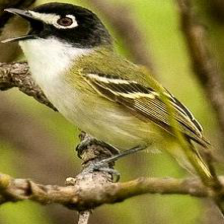

In [17]:
idx = 4342
img, label = val_loader.dataset[idx]
if dataset=='VOC2012':
    index = (label>0).nonzero().tolist()
    index = [t[0] for t in index]
else:
    index = label
print(index)
toPIL(img)

In [12]:
with torch.no_grad():
    p = model(img.unsqueeze(0).cuda(gpu))
print(p.squeeze(0) >0)
print(label>0)
print((p.squeeze(0) >0).nonzero())

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:2', dtype=torch.uint8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       dtype=torch.uint8)
tensor([[12],
        [14]], device='cuda:2')


In [18]:
def grad_cam(model, dataIn, index):
    model.eval()
    outs = model(dataIn)
    convOut = output_feat_list.pop()
    gradCAMs = []
    for idx in index:
        out = outs[0,idx]
        out.backward(retain_graph=True)
        gradOut = output_grad_list.pop()
        alpha = gradOut.mean([2,3], keepdim=True)
        gradcam = nn.ReLU()(torch.sum(convOut*alpha, [0,1]))
        gradCAMs.append(gradcam)
    model.zero_grad()
    return gradCAMs

In [19]:
def map_combine(image, heat_map, alpha=0.6, display=False, save=None, cmap='jet', axis='on', verbose=False):
    # resize heat map
    heat_map_resized = F.upsample(heat_map.resize(1,1,*heat_map.shape), (224,224), mode='bilinear').reshape(*image.size).numpy()

    # normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)

    # display
    plt.imshow(image)
    plt.imshow(255 * normalized_heat_map, alpha=alpha, cmap=cmap)
    plt.axis(axis)

    if display:
        plt.show()

    if save is not None:
        if verbose:
            print('save image: ' + save)
        plt.savefig(save, bbox_inches='tight', pad_inches=0)

In [20]:
def normalize_map(heat_map, image):
    # normalize heat map
    map_resized = F.upsample(heat_map.resize(1,1,*heat_map.shape), (224,224), mode='bilinear').reshape(*image.size).numpy()
    max_value = np.max(map_resized)
    min_value = np.min(map_resized)
    normalized_heat_map = (map_resized - min_value) / (max_value - min_value)
    return normalized_heat_map

In [21]:
def show_grad(grad):
    grad_show = grad - grad.min()
    grad_show /= grad_show.max()
    return T.ToPILImage()(grad_show)

In [22]:
def guided_gradcam(cam, gbp):
    cam_exp = F.upsample(cam.resize(1,1,*cam.shape), gbp.shape[1:], mode='bilinear').resize(1,*gbp.shape[1:])
    return cam_exp * gbp

In [25]:
def showcam(model, dataset, show_list, guide_backprop, save=False):
    cmap = 'jet'
    alpha = 0.6
    for i in show_list:
        img, label = dataset[i]
        if dataset=='VOC2012':
            index = (label>0).nonzero().tolist()
            index = [t[0] for t in index]
        else:
            index = [label]
        cams = grad_cam(model, img.unsqueeze(0).cuda(gpu), index)
        gradient = guide_backprop.generate_gradients(img.unsqueeze(0).cuda(gpu), index)

        fig1, axes = plt.subplots(len(index)+1,2,figsize=(12,12))
        fig1.suptitle("img: {:04d} arch {}".format(i,arch))
        img = toPIL(img)
        axes[0][0].imshow(img)
        axes[0][0].set_title('Grad-CAM')
        axes[0][1].imshow(show_grad(gradient))
        axes[0][1].set_title('Guided Grad-CAM')
        
        for k in range(len(index)):
            normalized_cam = normalize_map(cams[k], img)
            axes[k+1][0].imshow(img)
            axes[k+1][0].imshow(255 * normalized_cam, alpha=alpha, cmap=cmap)
            axes[k+1][0].set_title(id_class_map[index[k]])
            axes[k+1][1].imshow(show_grad(guided_gradcam(cams[k], gradient)))
            axes[k+1][1].set_title(id_class_map[index[k]])
        
#         fig1.tight_layout()
        plt.show()
        if save:
            plt.savefig('CAMs/'+f'val_{i}_{arch}.jpg', bbox_inches='tight', pad_inches=0)
    

In [1]:
showcam(model, train_loader.dataset, range(0,5000,60), GBP, save=False)

NameError: name 'showcam' is not defined

In [73]:
val_loader.dataset.__len__()

5823

In [18]:
cams = grad_cam(model, img.unsqueeze(0).cuda(gpu), index)

/usr/share/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/share/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/share/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


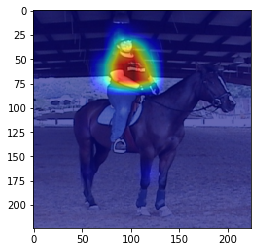

In [40]:
map_combine(toPIL(img), cams[1])

In [20]:
gradient = GBP.generate_gradients(img.unsqueeze(0).cuda(gpu), index)
gradient.shape

torch.Size([3, 224, 224])

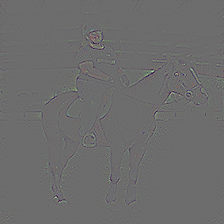

In [21]:
show_grad(gradient)

/usr/share/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/share/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/share/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


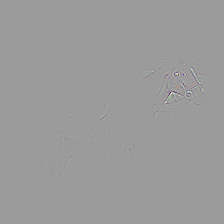

In [22]:
show_grad(guided_gradcam(cams[0],gradient))

In [54]:
ls /home/data1/ruofan/VOCdevkit/VOC2012/OurFiles/

id_class_map.npy  train_target.pkl  val_target.pkl
train_dirs.pkl    val_dirs.pkl


In [55]:
np.load('/home/data1/ruofan/VOCdevkit/VOC2012/OurFiles/id_class_map.npy')

array(['aeroplane_val.txt', 'bicycle_val.txt', 'bird_val.txt',
       'boat_val.txt', 'bottle_val.txt', 'bus_val.txt', 'car_val.txt',
       'cat_val.txt', 'chair_val.txt', 'cow_val.txt',
       'diningtable_val.txt', 'dog_val.txt', 'horse_val.txt',
       'motorbike_val.txt', 'person_val.txt', 'pottedplant_val.txt',
       'sheep_val.txt', 'sofa_val.txt', 'train_val.txt',
       'tvmonitor_val.txt'], dtype='<U19')